<center>

# Spam detection

## Alejandra Camelo Cruz

### Matrikelnummer: 800385

</center>


Import modules

In [1]:
#Preprocessing and plotting packages
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot as plt

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


create simple function for visualization of data

In [9]:
def pie_plot(data, title):
    unique, counts = np.unique(data, return_counts=True)
    plt.figure(figsize=(8,8))

    plt.pie(
        x=counts,
        labels=['ham', 'spam'],
        autopct='%1.1f%%',
        explode=[0.05, 0.05],
        colors=sns.color_palette('Set2'))

    plt.title(
        label=title,
        pad=20)

    #plt.savefig(f'plots/{title}.png')
    plt.show()


def evaluation(y_test, y_pred, title):
  accuracy = accuracy_score(y_test, y_pred)
  matrix = confusion_matrix(y_test, y_pred)
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(16,7))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
  class_names = ['ham', 'spam']
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.5
  plt.xticks(tick_marks, class_names, rotation=0)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  #plt.savefig(f'plots/{title}.png')

  print("Accuracy:", accuracy)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plt.show()


def parameter_test(x_train, x_test, y_train, y_test, max_depth=False):
  random = 4
  test = []
  if max_depth:
    title = 'max_depth'
    for num in range(1,100):
      clf = RandomForestClassifier(max_depth = num, random_state=random)
      clf.fit(x_train, y_train)
      y_pred = clf.predict(x_test)
      accuracy = accuracy_score(y_test, y_pred)
      test.append(accuracy)

    plt.plot(test)
    plt.savefig(f'plots/{title}.png')
    plt.show()

# Handle data

## Load data


In [5]:
# Load MATLAB file
mat_data = scipy.io.loadmat('emails.mat')

# Extract data
# I'll work with pandas dataframe
X = pd.DataFrame.sparse.from_spmatrix(mat_data['X'])
X = X.T #attributes are now columns and instances are rows
Y = mat_data['Y'][0]

How do data look like?

In [ ]:
# How do data look like?
missing_values = X.isnull().any()
no_missing = missing_values[missing_values.isin([True])].empty
print(f'There are no missing values: {no_missing}')

# Shape of dataframe
print(X.head())
print('shape of data: ', X.shape)

There are no missing values: True
   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   57163  57164  57165  57166  57167  57168  57169  57170  57171  57172  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 57173 columns]
shape of data: 

Plot how data are distributed

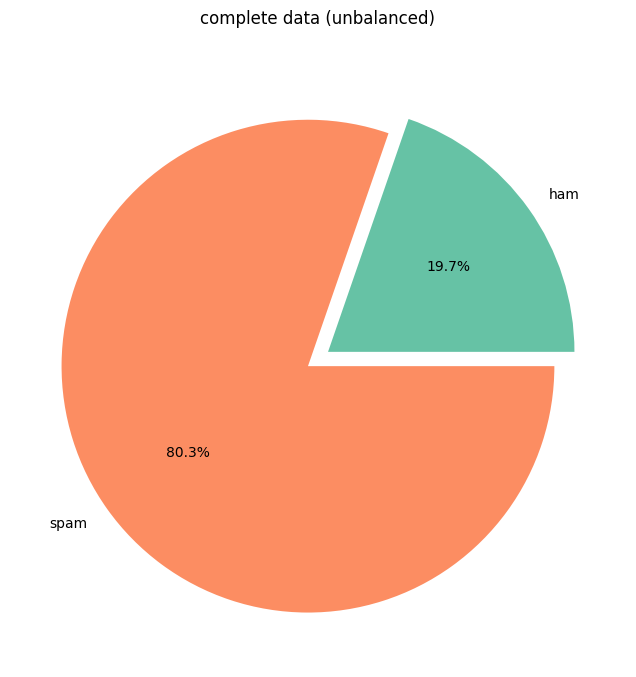

In [6]:
# Plot how data are distributed
pie_plot(Y, 'complete data (unbalanced)')

Data are mild unbalanced. However, I'll check how the model work with original data

In [ ]:
# Data is mildly unbalanced but model can be tried
#1. Split train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=4)

# Random forest
Try a first model and see how it performs

2. create a classifier and fit it with training data
3. Make predictions and evaluate model

Accuracy: 0.9976
[[ 462    6]
 [   0 2032]]
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       468
           1       1.00      1.00      1.00      2032

    accuracy                           1.00      2500
   macro avg       1.00      0.99      1.00      2500
weighted avg       1.00      1.00      1.00      2500



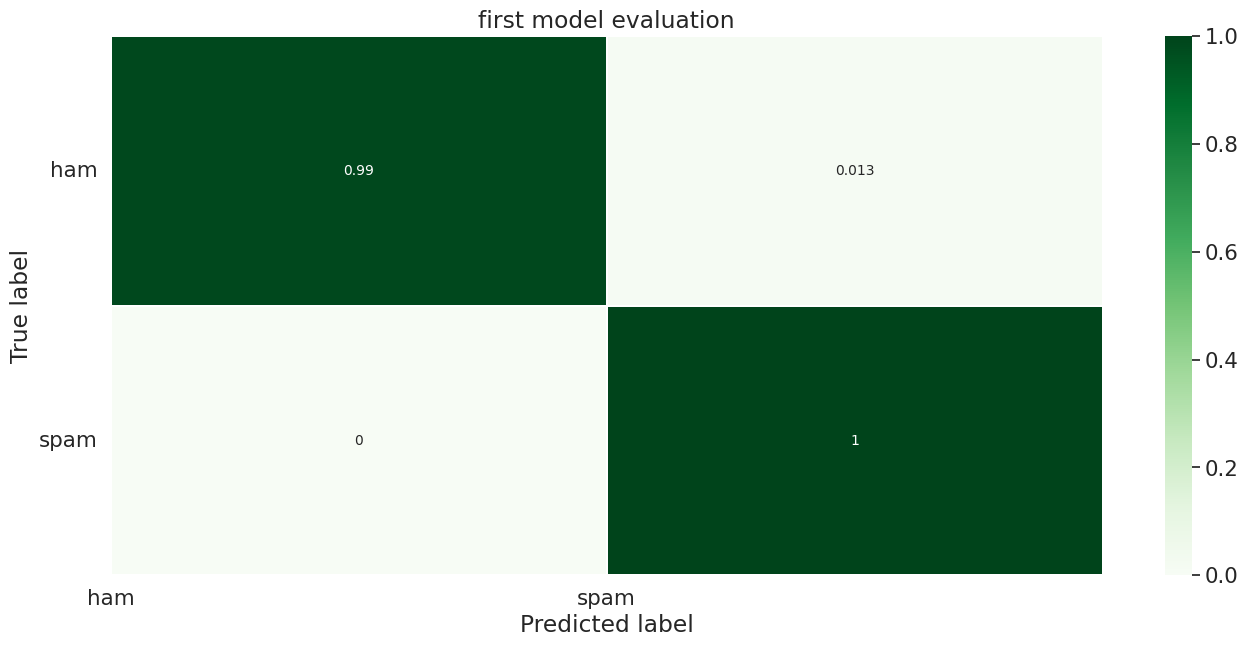

In [15]:
#2. Create and fit classifier
clf = RandomForestClassifier(random_state=4)
clf.fit(x_train, y_train)

#3. Evaluate
y_pred = clf.predict(x_test)
evaluation(y_test, y_pred, 'first model evaluation')

In [ ]:
#clf.get_params()

check for better hyperparameters


In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

clf = RandomForestClassifier(random_state=4)
clf_tuned = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                               n_iter = 1, cv = 3, verbose=2,
                               random_state=4, n_jobs = -1)

clf_tuned.fit(x_train, y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: ignored